In [684]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [685]:
from locale import atof
    
def parseNdValue(x):
    x = x.replace(',', '.')
    if (x == 'n/d'):
        return '0.0'
    else:
        return x
def parseMValue(x):
    if ('M' in x):
        return str(float(x.replace('M','').replace(',', '.')) *  1000000)
    else:
        return x

In [686]:
#Lendo csv
df = pd.read_csv("./itsa4-historico.csv", delimiter=',')

# Muda o tipo dos dados
df['ABERTURA'] = df['ABERTURA'].apply(parseNdValue).map(atof)
df['FECHAMENTO'] = df['FECHAMENTO'].apply(parseNdValue).map(atof)
df['VARIAÇÃO'] = df['VARIAÇÃO'].apply(parseNdValue).map(atof)
df['MÍNIMO'] = df['MÍNIMO'].apply(parseNdValue).map(atof)
df['MÁXIMO'] = df['MÁXIMO'].apply(parseNdValue).map(atof)
df['VOLUME'] = df['VOLUME'].apply(parseMValue).map(atof)
df["DATA"] = pd.to_datetime(df["DATA"], format='%d/%m/%Y')

df = df.sort_values(by="DATA")
df = df.reset_index(drop=True)

#criando novos campos de medias móveis
df['mm5d'] = df['FECHAMENTO'].rolling(5).mean()
df['mm21d'] = df['FECHAMENTO'].rolling(21).mean()

In [687]:
#retirando os dados nulos
df.dropna(inplace=True)

#reindexando o data frame
df = df.reset_index(drop=True)

In [688]:
#separando as features e labels
features = df.drop(['FECHAMENTO', 'DATA', 'mm21d'], 1)
labels = df['FECHAMENTO']
features

/tmp/ipykernel_59982/2402583205.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features = df.drop(['FECHAMENTO', 'DATA', 'mm21d'], 1)


,ABERTURA,VARIAÇÃO,MÍNIMO,MÁXIMO,VOLUME,mm5d
0,10.92,0.58,10.69,10.93,188800000.0,10.758
1,10.82,-3.04,10.39,10.85,271030000.0,10.754
2,10.27,-2.28,10.15,10.44,353830000.0,10.678
3,9.74,-6.31,9.53,9.78,437370000.0,10.414
4,10.07,2.12,9.59,10.29,462990000.0,10.222
...,...,...,...,...,...,...
481,10.13,-1.67,9.94,10.15,381040000.0,10.120
482,9.98,1.10,9.92,10.13,296920000.0,10.124
483,10.51,4.26,10.36,10.65,783190000.0,10.174
484,10.54,-0.38,10.45,10.56,254700000.0,10.244


In [689]:

#Escolhendo as melhores features com Kbest
features_list = ('ABERTURA','VARIAÇÃO','MÍNIMO', 'VOLUME', 'MÁXIMO','mm21d','mm5d')

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()
print ('')
print ("Melhores features:")
print (k_best_features_final)

features = df.loc[:,['VOLUME', 'MÁXIMO', 'VARIAÇÃO', 'mm5d']]
features
print('___>')
print(features.tail())


Melhores features:
{'VOLUME': 174.52483223498655, 'MÁXIMO': 164.43746347708273, 'mm5d': 47.234456893697185, 'VARIAÇÃO': 2.2782897686573453, 'MÍNIMO': 2.2703733862211277, 'mm21d': 0.8008387062159648}
___>
          VOLUME  MÁXIMO  VARIAÇÃO    mm5d
481  381040000.0   10.15     -1.67  10.120
482  296920000.0   10.13      1.10  10.124
483  783190000.0   10.65      4.26  10.174
484  254700000.0   10.56     -0.38  10.244
485  249080000.0   10.65      1.24  10.336


In [690]:
#verificando quantidade de linhas
qtd_linhas = len(df)

qtd_linhas_treino= round(.60 * qtd_linhas)
qtd_linhas_teste= qtd_linhas - qtd_linhas_treino  
qtd_linhas_validacao = qtd_linhas -1

info = (
    f"linhas treino= 0:{qtd_linhas_treino}"
    f" linhas teste= {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste -1}"
    f" linhas validação= {qtd_linhas_validacao}"
)

print(info)

linhas treino= 0:292 linhas teste= 292:485 linhas validação= 485


In [691]:
#Separa os dados de treino teste e validação
X_train = features[:qtd_linhas_treino]
X_test = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

y_train = labels[:qtd_linhas_treino]
y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

print('X_train y_train')
print( len(X_train), len(y_train))

print('X_test y_test')
print( len(X_test), len(y_test))

print('')

# Normalizando os dados de entrada(features)



X_train y_train
292 292
X_test y_test
193 193



In [692]:
# # Gerando o novo padrão
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

In [693]:
#treinamento usando regressão linear
lr = LinearRegression()
lr.fit(X_train_scale, y_train)
pred = lr.predict(X_test_scale)
cd = r2_score(y_test, pred)

f'Coeficiente de determinação:{cd:.2f}'


'Coeficiente de determinação:0.99'

In [694]:
def pred_future_price(df, days):
    import datetime
    df = df.loc[:,['VOLUME', 'MÁXIMO', 'VARIAÇÃO', 'DATA', 'FECHAMENTO', 'ABERTURA', 'MÍNIMO', 'mm5d']]
    for x in np.arange(days):
        ultimoPregao = df.tail(1)  
        previsao  = scaler.transform(ultimoPregao.drop(['DATA', 'FECHAMENTO', 'ABERTURA', 'MÍNIMO'], axis=1))
        pred_loop = lr.predict(previsao)
        proximaData = df.tail(1)['DATA'] + datetime.timedelta(days=1)
        mm5d = df['FECHAMENTO'].rolling(5).mean().tail(1)
        df = df.append(pd.DataFrame(
            {
                'ABERTURA': df.tail(1)['FECHAMENTO'], 
                'FECHAMENTO': pred_loop, 
                'VARIAÇÃO': pred_loop - df.tail(1)['FECHAMENTO'],
                'MÍNIMO': [0],
                'MÁXIMO': pred_loop,
                'VOLUME': [0], 
                'DATA': proximaData,
                'mm5d': mm5d
            }))
        df = df.reset_index(drop=True)
    return df

In [695]:
days_to_pred = 10
df_pred = pred_future_price(df, days_to_pred)
print(df_pred.loc[:,['DATA', 'FECHAMENTO']].tail(days_to_pred + 1))

          DATA  FECHAMENTO
485 2022-02-15   10.610000
486 2022-02-16   10.549637
487 2022-02-17   10.504626
488 2022-02-18   10.490568
489 2022-02-19   10.496399
490 2022-02-20   10.500706
491 2022-02-21   10.504848
492 2022-02-22   10.503938
493 2022-02-23   10.501252
494 2022-02-24   10.498954
495 2022-02-25   10.497496


              real   previsao
data_pregao                  
2022-02-09    9.98  10.120560
2022-02-10   10.09   9.954561
2022-02-11   10.52  10.059386
2022-02-14   10.48  10.444788
2022-02-15   10.61  10.401137


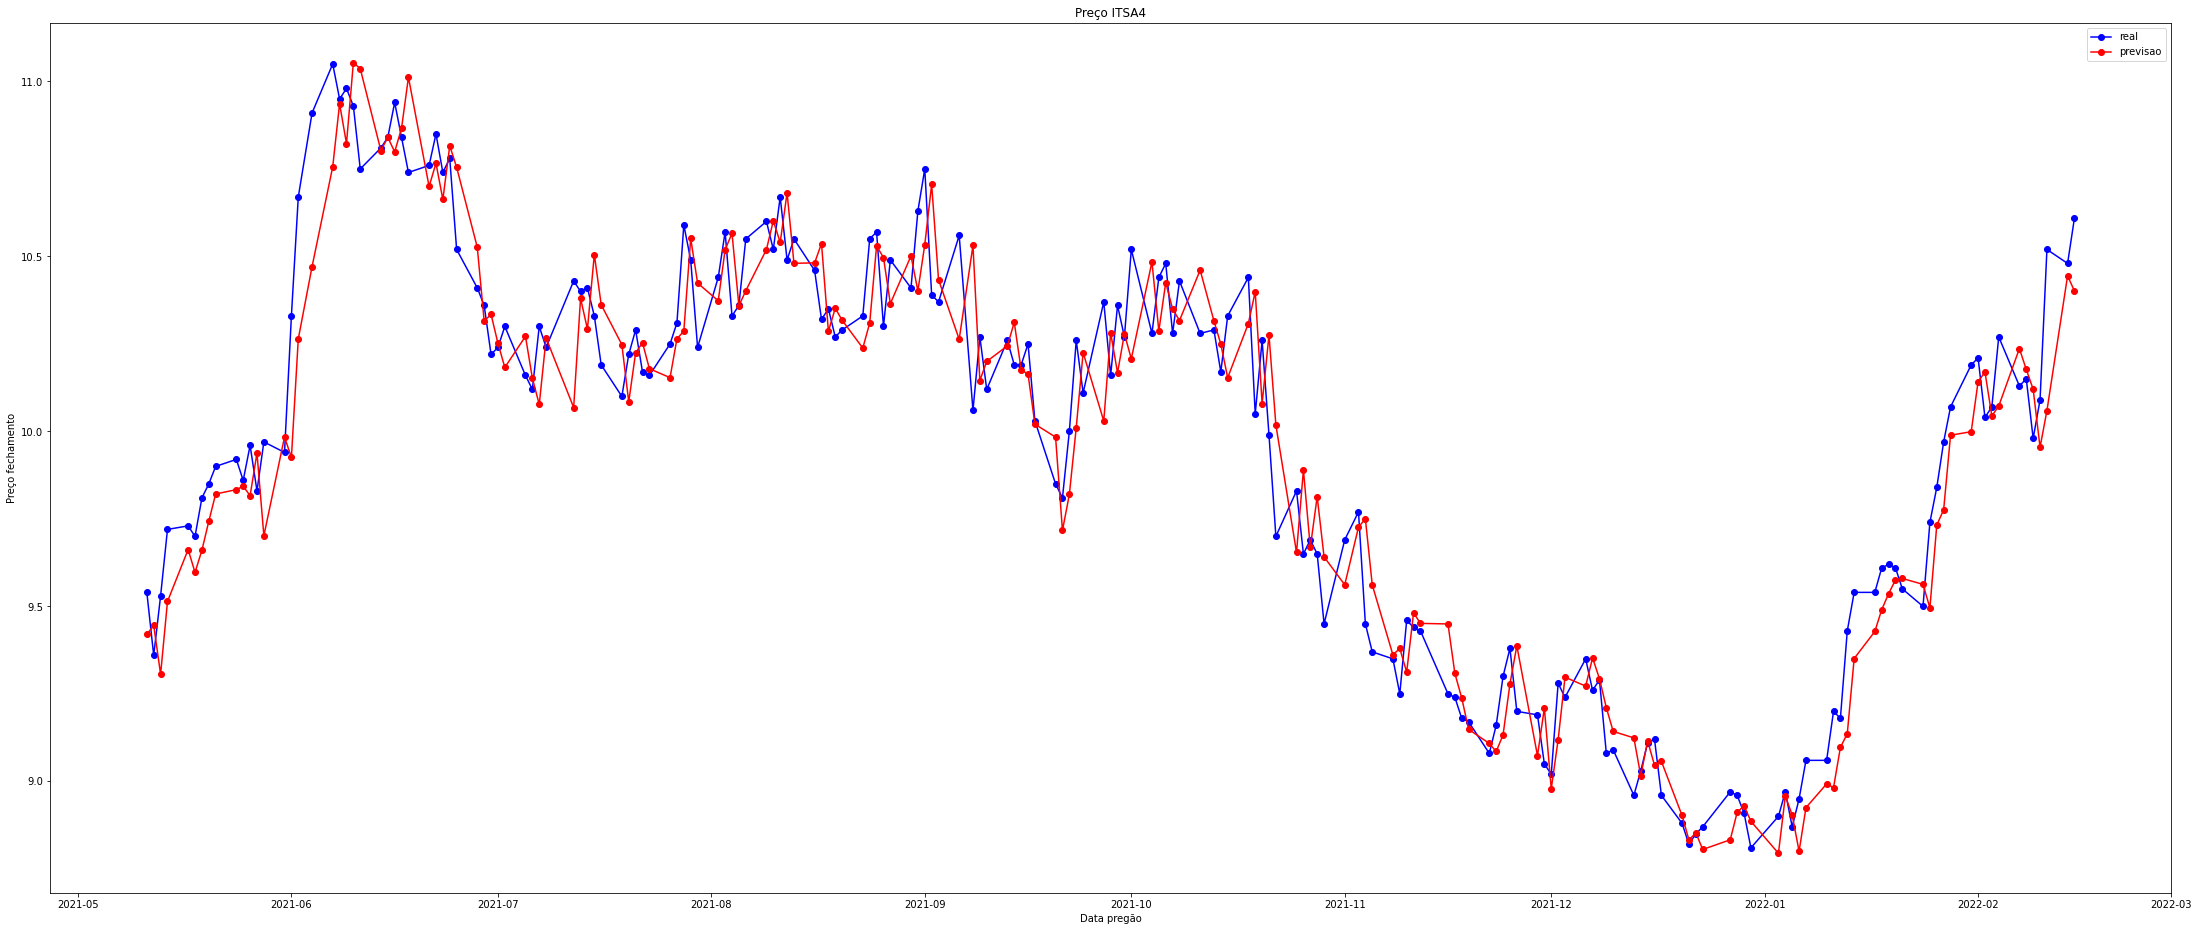

In [696]:
data_pregao_full = df['DATA']
data_pregao = data_pregao_full.tail(qtd_linhas_teste - 1)

res_full = df['FECHAMENTO']
res = res_full.tail(qtd_linhas_teste - 1)

df_chart = pd.DataFrame({'data_pregao': data_pregao, 'real':res, 'previsao': pred[:qtd_linhas_teste - 1] })
df_chart.set_index('data_pregao', inplace=True)

print(df_chart.tail())

#Gráfico
plt.figure(figsize=(38,16))
plt.title('Preço ITSA4')
plt.plot(df_chart['real'], label='real', color='blue', marker='o')
plt.plot(df_chart['previsao'], label='previsao', color='red', marker='o')
plt.xlabel('Data pregão')
plt.ylabel('Preço fechamento')
leg = plt.legend()